In [0]:
!pip3 install torch
!pip3 install pydub
!pip3 install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=4ac1923d8f9238f39ed094de888895afcc523273fbfc99427f5e71506b3baf27
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


### Import all packages

In [0]:
# from hw2
import pydub
from pydub import AudioSegment
import pydub
from pydub.playback import play
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import sleep
import scipy.io.wavfile as wav
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import numpy as np
import pandas as pd
import os

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Preparing the dataset

In [0]:
#!ls /content/drive/'My Drive'/validated_clips/validated_clip/1.000000
downloaded_files = glob("/content/drive/My Drive/validated_clips/validated_clip/**/*.mp3", recursive=True)
num_downloaded_files = len(downloaded_files)
print(num_downloaded_files)

207266


drive  sample_data


In [0]:
dev = pd.read_csv("/content/drive/My Drive/tsvs/dev.tsv", sep="\t")
train = pd.read_csv("/content/drive/My Drive/tsvs/train.tsv", sep="\t")
test = pd.read_csv("/content/drive/My Drive/tsvs/test.tsv", sep="\t")
validated = pd.read_csv("/content/drive/My Drive/tsvs/validated.tsv", sep="\t")
invalidated = pd.read_csv("/content/drive/My Drive/tsvs/invalidated.tsv", sep="\t")
#print(dev)
#TODO use numpy arrays instead dataframes
#TODO how are we balancing classes?
splits = {
    "dev": dev,
    "train": train, 
    "test": test,
    "validated": validated,
    "invalidated": invalidated
}

In [0]:
#print(splits)

#### Fix the paths

In [0]:
#TODO: Fix prefixes
prefix = "./data/audios/"
for key in splits:
    splits[key]['path'] = prefix + splits[key]['path'].astype(str)

In [0]:
#print(splits)

#### Drop the rows with NaN accent values

In [0]:
for key in splits:
    print(key, len(splits[key]))

dev 15531
train 232975
test 15531
validated 218400
invalidated 124820


In [0]:
for key in splits:
    splits[key].dropna(axis=0, subset=["accent"], inplace=True)
    print(len(splits[key]))

2100
135391
1398
46169
46728


#### Drop the rows yet to be validated

In [0]:
train.columns

Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accent'],
      dtype='object')

In [0]:
columns = ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent']

# https://stackoverflow.com/questions/26921943/pandas-intersection-of-two-data-frames-based-on-column-entries
train_validated = pd.merge(train, validated, how='inner', on=columns)
test_validated = pd.merge(test, validated, how='inner', on=columns)
dev_validated = pd.merge(dev, validated, how='inner', on=columns)

In [0]:
print(f"The overall dataset has {len(train_validated)} training, {len(test_validated)} test and {len(dev_validated)} dev validated audio files.")

The overall dataset has 14480 training, 1398 test and 2100 dev validated audio files.


#### Lets look at the overall data

In [0]:
# visualize categorical data https://www.datacamp.com/community/tutorials/categorical-data
def visualize_categorical_distribution(pd_series, title="Plot", ylabel='Number of Samples', xlabel='Accent', figsize=None):
    digit_counts = pd_series.value_counts()
    sns.set(style="darkgrid")
    if figsize is None:
        sns.set(rc={'figure.figsize':(10,6)})
    else:
        sns.set(rc={'figure.figsize':figsize})
    sns.barplot(digit_counts.index, digit_counts.values, alpha=0.9)
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.show()

In [0]:
print(splits["train"].groupby(['accent', 'gender']).size())
print(splits["dev"].groupby(['accent', 'gender']).size())
print(splits["test"].groupby(['accent', 'gender']).size())
print(splits['train']['accent'].value_counts())

accent       gender
african      female       8
             male        28
australia    female      71
             male       259
             other      272
bermuda      male         2
canada       female     112
             male       558
england      female     431
             male      1799
             other       21
indian       female      72
             male       452
ireland      female      49
             male        79
malaysia     male         5
newzealand   female      74
             male       110
philippines  male        37
scotland     female     151
             male       166
singapore    female      17
             male       160
us           female    1648
             male      2673
             other      164
dtype: int64
accent       gender
african      male      12
australia    female     9
             male      18
canada       female    15
             male      12
england      female     8
             male      41
indian       male      16
newzealand 

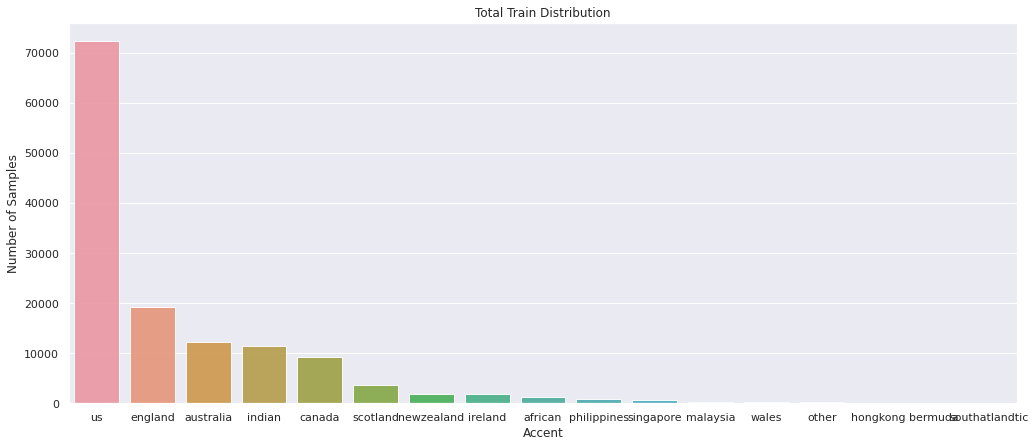

In [0]:
visualize_categorical_distribution(splits["train"]["accent"], "Total Train Distribution", figsize=(17,7))

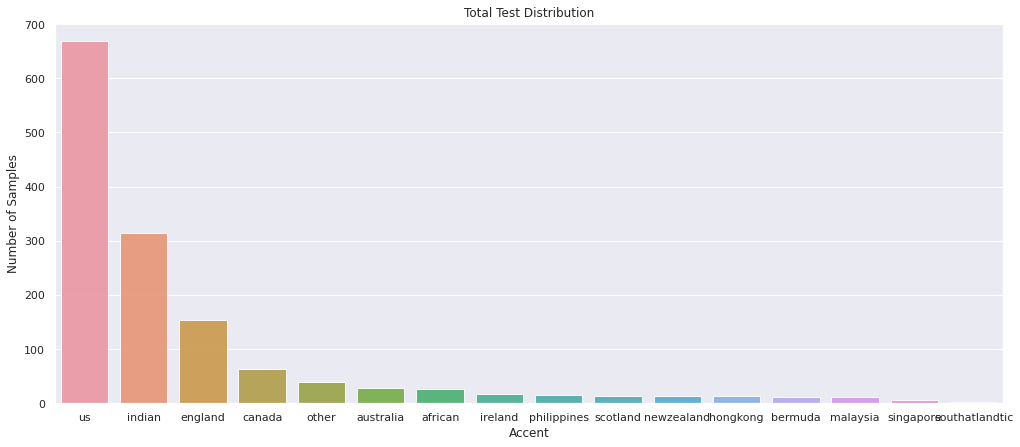

In [0]:
visualize_categorical_distribution(splits["test"]["accent"], "Total Test Distribution", figsize=(17,7))

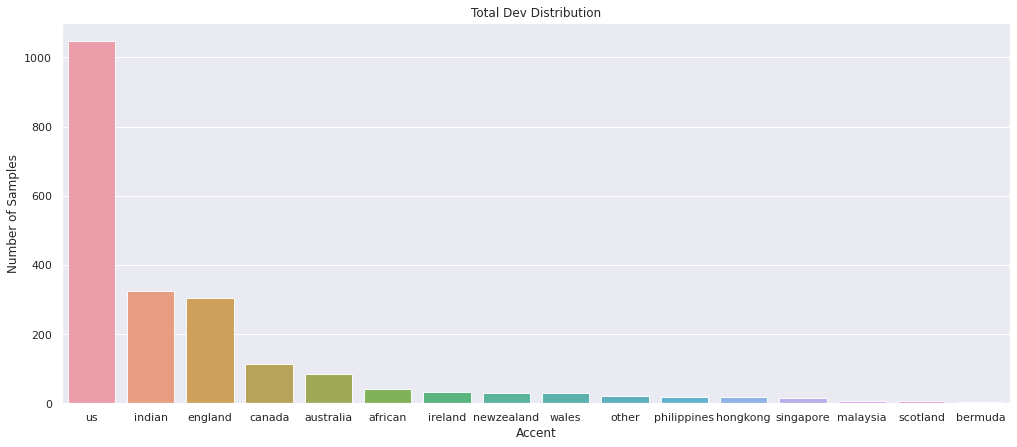

In [0]:
visualize_categorical_distribution(splits["dev"]["accent"], "Total Dev Distribution", figsize=(17,7))

Lets look at some other attributes...

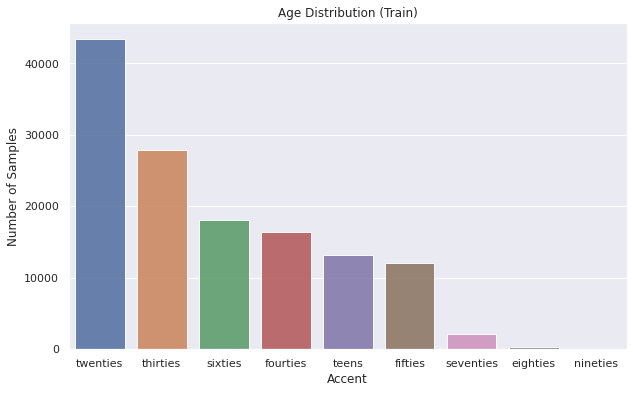

In [0]:
visualize_categorical_distribution(splits["train"]["age"], "Age Distribution (Train)")

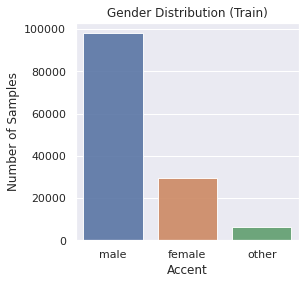

In [0]:
visualize_categorical_distribution(splits["train"]["gender"], "Gender Distribution (Train)", figsize=(4,4))

#### What about the overall validated data?

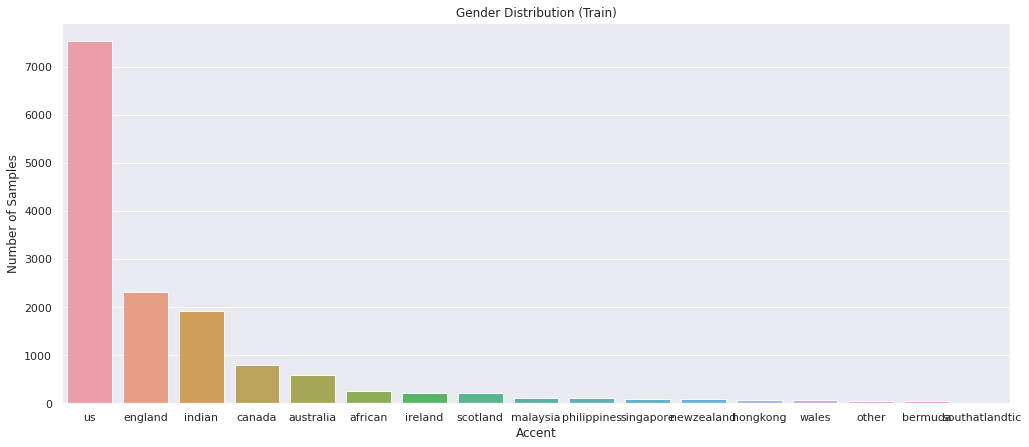

In [0]:
visualize_categorical_distribution(train_validated["accent"], "Gender Distribution (Train)", figsize=(17,7))

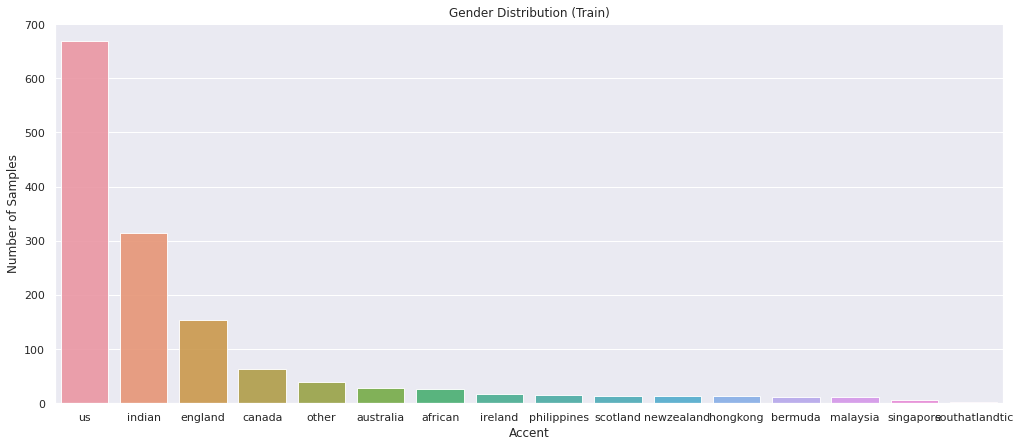

In [0]:
visualize_categorical_distribution(test_validated["accent"], "Gender Distribution (Train)", figsize=(17,7))

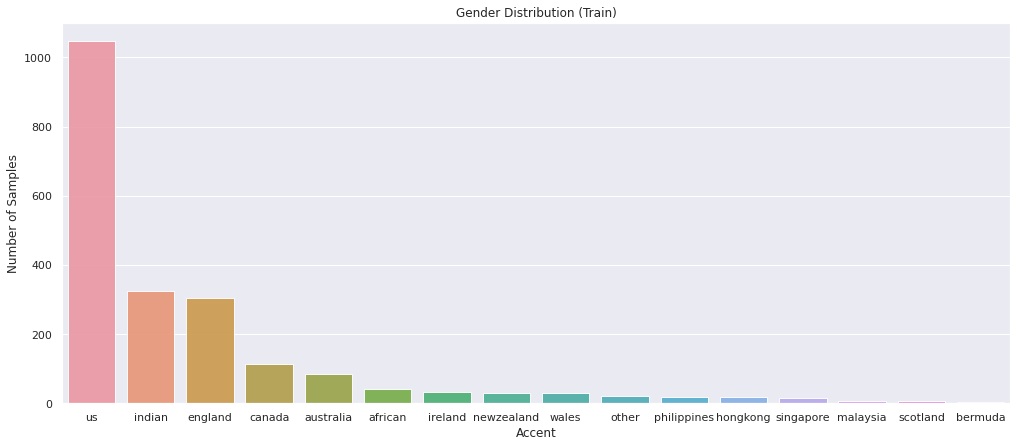

In [0]:
visualize_categorical_distribution(dev_validated["accent"], "Gender Distribution (Train)", figsize=(17,7))

In [0]:
print(num_downloaded_files)
print(downloaded_files)
print(splits['train']['path'])

35339
['./data/audios/common_voice_en_19560169.mp3', './data/audios/common_voice_en_19560170.mp3', './data/audios/common_voice_en_19560171.mp3', './data/audios/common_voice_en_19560172.mp3', './data/audios/common_voice_en_19560173.mp3', './data/audios/common_voice_en_19560229.mp3', './data/audios/common_voice_en_19560230.mp3', './data/audios/common_voice_en_19560231.mp3', './data/audios/common_voice_en_19560232.mp3', './data/audios/common_voice_en_19560233.mp3', './data/audios/common_voice_en_19560243.mp3', './data/audios/common_voice_en_19560245.mp3', './data/audios/common_voice_en_19560246.mp3', './data/audios/common_voice_en_19560247.mp3', './data/audios/common_voice_en_19560698.mp3', './data/audios/common_voice_en_19560739.mp3', './data/audios/common_voice_en_19560740.mp3', './data/audios/common_voice_en_19560741.mp3', './data/audios/common_voice_en_19560742.mp3', './data/audios/common_voice_en_19560743.mp3', './data/audios/common_voice_en_19560749.mp3', './data/audios/common_voice

#### Choose the data we've actually downloaded

In [0]:
for key in splits:
    splits[key] = splits[key][splits[key]["path"].isin(downloaded_files)]
    print(len(splits[key]))
print(splits)

279
9426
69
2144
1595
{'dev':                                                client_id  \
184    d908edc4dc0466f305fa5e73b6c97b7ccef2719bd02c0f...   
185    d908edc4dc0466f305fa5e73b6c97b7ccef2719bd02c0f...   
186    d908edc4dc0466f305fa5e73b6c97b7ccef2719bd02c0f...   
1323   0134a425dfbdd75a77ca734d7601de78eb4c9e016396b0...   
1324   0134a425dfbdd75a77ca734d7601de78eb4c9e016396b0...   
...                                                  ...   
15267  4ae3e06f9d0b402a16aa5d2071a0215f4fc4695eb3018f...   
15268  4ae3e06f9d0b402a16aa5d2071a0215f4fc4695eb3018f...   
15269  4ae3e06f9d0b402a16aa5d2071a0215f4fc4695eb3018f...   
15270  4ae3e06f9d0b402a16aa5d2071a0215f4fc4695eb3018f...   
15271  4ae3e06f9d0b402a16aa5d2071a0215f4fc4695eb3018f...   

                                             path  \
184    ./data/audios/common_voice_en_19752781.mp3   
185    ./data/audios/common_voice_en_19752782.mp3   
186    ./data/audios/common_voice_en_19752783.mp3   
1323   ./data/audios/common_voice_en_

#### Make sure speaker independent and validated

In [0]:
len(splits['train'][splits['train']["client_id"].isin(splits['test']['client_id'])])

0

In [0]:
len(splits['train'][splits['train']["client_id"].isin(splits['dev']['client_id'])])

0

In [0]:
num_train = len(splits['train'][splits['train']["client_id"].isin(splits['validated']['client_id'])])
num_test = len(splits['test'][splits['test']["client_id"].isin(splits['validated']['client_id'])])
num_dev = len(splits['dev'][splits['dev']["client_id"].isin(splits['validated']['client_id'])])

print(f"Wow, we only end up with {num_train} training, {num_test} test and {num_dev} dev audio files from the {num_downloaded_files} files we started with!")

Wow, we only end up with 1766 training, 69 test and 279 dev audio files from the 35339 files we started with!


## For the purposes of this toy example we forgoe using only the validated clips and assume all clips are good. 

#### Lets take a look at some of our downloaded data

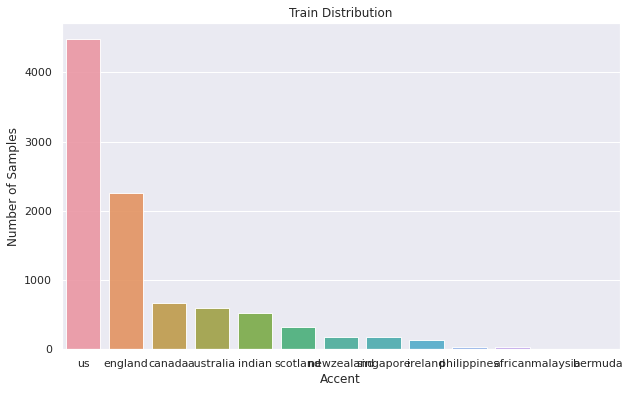

In [0]:
visualize_categorical_distribution(splits["train"]["accent"], "Train Distribution")

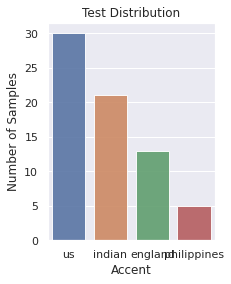

In [0]:
visualize_categorical_distribution(splits["test"]["accent"], "Test Distribution", figsize=(3,4))

Lets play some audio files

In [0]:
def play_mp3_from_path(relative_path):
    """plays mp3 located at provided relative path, returns the audio segment"""
    a = pydub.AudioSegment.from_mp3(relative_path)
    # test that it sounds right (requires ffplay, or pyaudio):
    print(a)
    play(a)
    return a

In [0]:
# pick 4 random audio files from first 10
#paths = np.random.choice(splits["train"]["path"][:10], size=4)

#for path in paths:
#    print(path)
#    play_mp3_from_path(path)

# Yikes... That is a bad distribution.

#### Lets start preprocessing our actual audio files to the dataset

Some useful functions:

In [0]:
from utils import *

##### Extract the audio files, remove leading silence, and silent clips...

In [0]:
train = splits["train"]
train = train[:30]

In [0]:
# Remove silent clips
drop_idxs = train[train['path'].apply(detect_leading_silence_filepath) >= train['path'].apply(length_of_file)-1].index
train = train.drop(drop_idxs)

In [0]:
# Zero pad to normalize length
downloaded_audios = [pydub.AudioSegment.from_mp3(f) for f in train['path']]

In [0]:
max_audio_length = np.max([len(sample) for sample in downloaded_audios])
print(f"max audio length is {max_audio_length / 1000} seconds")

max audio length is 9.816 seconds


In [0]:
padded_audios = [zero_pad_in_end(audio, max_audio_length) for audio in downloaded_audios]

In [0]:
mfccs_padded = np.array([extract_mfcc(audio) for audio in padded_audios])

In [0]:
audio_embeddings = pd.DataFrame({
    'label': train['accent'], 
    'mfcc': np.array([extract_mfcc(audio) for audio in downloaded_audios]),
    'mfb': np.array([extract_mfb(audio) for audio in downloaded_audios]),
    'mfcc_padded': np.array([extract_mfcc(audio) for audio in padded_audios]),
    'mfb_padded': np.array([extract_mfb(audio) for audio in padded_audios])
})

Exception: Data must be 1-dimensional

In [0]:
labels = train['accent'].to_numpy()
labels

array(['england', 'england', 'england', 'england', 'england', 'us', 'us',
       'us', 'us', 'us', 'canada', 'canada', 'canada', 'canada', 'canada',
       'us', 'us', 'us', 'us', 'us', 'england', 'england', 'england',
       'england', 'england', 'us', 'us', 'us', 'us', 'us'], dtype=object)

In [0]:
paddingamounts = [(len(pad)-len(unpad))/1000 for unpad,pad in zip(downloaded_audios, padded_audios)]
print(paddingamounts)
print(sum(paddingamounts)/len(paddingamounts))

[0.408, 3.192, 0.0, 1.752, 2.376, 2.808, 2.904, 2.208, 3.96, 0.888, 2.016, 2.784, 3.192, 4.056, 3.84, 4.728, 3.552, 5.88, 6.36, 3.744, 2.76, 4.272, 3.432, 3.528, 3.576, 0.84, 4.872, 2.928, 4.704, 5.208]
3.2256


In [0]:
print([len(audio) for audio in audio_embeddings["mfcc_padded"]])

In [0]:
print([extract_mfcc(audio).shape for audio in padded_audios])

#TODO: Plot some filterbanks and mfccs

#TODO: Constant size features for CNN

#### TODO:: Create a validation set?

#### TODO: Creating our Toy Models

##### Toy CNN

In [0]:
mfccs_padded = np.moveaxis(mfccs_padded, (1,2), (2,1))
mfccs_padded.shape
#want array size to be
#numbe of samples, number of filterbanks, length of each sample

(30, 13, 2944)

In [0]:
class downwardSlope(nn.Module):
    def __init__(self, maxSeqLength, outsize):
        super().__init__()
        self.maxSeqLength = maxSeqLength

        self.conv1 = nn.Conv1d(13, 32, 15, padding=1)
        self.conv2 = nn.Conv1d(32, 32, 15, padding=1)
        self.conv3 = nn.Conv1d(32, 32, 15, padding=1)
        self.fc1 = nn.Linear(2908, outsize)

    def forward(self,x):
        print("insideforward",type(x), x.dtype)
        x= self.conv1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return torch.squeeze(x)

In [0]:
def evaluateModel(model, lossCriterion, X, y, batchSize):
    with torch.no_grad():
        n=batchSize
        batched = list(zip([X[i:i + n] for i in range(0, len(X), n)],
                          [y[i:i + n] for i in range(0, len(y), n)]))
        predList = []
        yList = []
        lossMeans = []
        for i,(batchX, batchY) in enumerate(batched):
            print('x',type(X), X.dtype)
            print('batchx',type(batchX), batchX.dtype)
            predProb = model(batchX)
            if np.isnan(predProb.cpu().detach().numpy()).any():
                print("AAAAAA a NAN")
                return
            loss = lossCriterion(predProb, batchY)
            batchPred = predProb.round().tolist()
            predList = predList+batchPred
            batchYargmaxed = batchY.tolist()
            yList = yList+batchYargmaxed
            lossMeans.append(torch.mean(loss).item())

        #acc = accuracy_score(yList, predList)
        #report = classification_report(yList, predList)
        #confMat = confusion_matrix(yList, predList)
        lossMean = sum(lossMeans)/float(len(lossMeans))

    return lossMean

In [0]:
def trainModel(model, optimizer, criterion, train_X, train_y, val_X, val_y, batchSize, startEpoch, endEpoch):
    notifyEvery = 100 if torch.cuda.is_available() else 2

    checkmarkTime = time.time()

    n=batchSize
    batched = list(zip([train_X[i:i + n] for i in range(0, len(train_X), n)],
                      [train_y[i:i + n] for i in range(0, len(train_y), n)]))
    numBatches = len(batched)
    print("number of batches", numBatches)
    for epoch in range(startEpoch, endEpoch):
        print("epoch:", epoch)
        for i,(batchX,batchy) in enumerate(batched):
            optimizer.zero_grad()
            output =  model(batchX)
            loss = criterion(output, batchy)
            loss.backward()
            optimizer.step()
            if np.isnan(output.cpu().detach().numpy()).any():
                print("AAAAAA a NAN")
                return
            if i%notifyEvery ==notifyEvery-1:
                print('[%d, %5d]' %
                  (epoch + 1, i + 1))
                timeTook = time.time() - checkmarkTime
                print("took", timeTook, "seconds for", notifyEvery, "batches")
                if(torch.cuda.is_available()):
                    print(torch.cuda.max_memory_allocated()/1e9, "GB of VRAM being used")
                checkmarkTime = time.time()
        trainLoss = evaluateModel(model,criterion,train_X, train_y, batchSize)
        valLoss = evaluateModel(model, criterion,val_X, val_y, batchSize)
        print('loss', valLoss)
    print("finished training")

In [0]:
!pip3 install skorch

In [0]:
from skorch import NeuralNetClassifier

/home/humzah/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

X = torch.as_tensor(mfccs_padded, dtype=torch.float)
le = preprocessing.LabelEncoder()
le.fit(labels)
transformed = le.transform(labels)
print(type(transformed),transformed.shape, print(transformed))
enc =  preprocessing.OneHotEncoder(handle_unknown='ignore')
onehotted =enc.fit_transform(transformed.reshape(-1,1)).toarray() 
optimizer = torch.optim.Adam(mod.parameters(), lr = learningRate)

y = torch.as_tensor(onehotted, dtype=torch.long)
outsize = len(le.classes_)
print(outsize, type(onehotted), type(y), onehotted.shape)

device = "cpu"
seqLength = mfccs_padded.shape[2]
mod = downwardSlope(seqLength, outsize)
criterion = nn.CrossEntropyLoss()
endEpoch = 3
learningRate = 0.001
print('x',type(X), X.dtype)
trainModel(mod, optimizer,criterion, X[:20], y[:20],X[20:],y[20:], 10, 0, 10)

[1 1 1 1 1 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2]
<class 'numpy.ndarray'> (30,) None
3 <class 'numpy.ndarray'> <class 'torch.Tensor'> (30, 3)
x <class 'torch.Tensor'> torch.float32
number of batches 2
epoch: 0
insideforward <class 'torch.Tensor'> torch.float32
insideforward <class 'torch.Tensor'> torch.float32
[1,     2]
took 0.1620330810546875 seconds for 2 batches
x <class 'torch.Tensor'> torch.float32
batchx <class 'torch.Tensor'> torch.float32
insideforward <class 'torch.Tensor'> torch.float32
x <class 'torch.Tensor'> torch.float32
batchx <class 'torch.Tensor'> torch.float32
insideforward <class 'torch.Tensor'> torch.float32
x <class 'torch.Tensor'> torch.float32
batchx <class 'torch.Tensor'> torch.float32
insideforward <class 'torch.Tensor'> torch.float32
loss 3.497631072998047
epoch: 1
insideforward <class 'torch.Tensor'> torch.float32
insideforward <class 'torch.Tensor'> torch.float32
[2,     2]
took 0.1870718002319336 seconds for 2 batches
x <class 'torch.Tensor'> t

##### Toy LSTM

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html